In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count,col,mean

spark = SparkSession.builder.getOrCreate()

In [32]:
# in the file there is an error to parse a csv because  double double quotes: ""... ""
# we'll use sed for simplicity
!cat ./work/data/listings.csv | sed 's/""/"/g' > ./work/data/listings_fixed.csv

In [33]:
listings_df = spark.read.option("header", "true").option("sep", ",").csv("./work/data/listings_fixed.csv")
loyer_df = spark.read.option("header", "true").option("sep",";").csv("./work/data/loyers.csv")

In [34]:
# count property_type
listings_df.groupBy("property_type").agg(count("property_type").alias("count")).sort("count", ascending=False).show(5)

+--------------------+-----+
|       property_type|count|
+--------------------+-----+
|  Entire rental unit|13935|
|           "Heating"| 3739|
|              "Wifi"| 3493|
|           "Kitchen"| 3472|
| "Dishes and silv...| 3382|
+--------------------+-----+
only showing top 5 rows



In [35]:
listings_df.groupBy("room_type").agg(count("room_type").alias("count")).sort("count", ascending=False).show(5)

+--------------------+-----+
|           room_type|count|
+--------------------+-----+
|     Entire home/apt|15110|
| "Dishes and silv...| 4357|
|           "Kitchen"| 3713|
|           "Heating"| 2936|
|            "Washer"| 2929|
+--------------------+-----+
only showing top 5 rows



In [36]:
listings_filter_cols_df = listings_df.select("id","room_type","price","availability_365", "longitude", "latitude", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "amenities", "availability_30", "availability_60", "availability_90", "availability_365")
listings_filter_cols_df = listings_filter_cols_df.filter(col("property_type") == "Entire rental unit").filter(col("room_type") == "Entire home/apt")
# filter na in cols 

In [37]:
listings_filter_cols_df.show(5)
panda_frame = listings_filter_cols_df.toPandas()
# parse price: replace '$' by '' and parse it to double
listings_filter_cols_df = listings_filter_cols_df.withColumn("price", col("price").substr(2, 100))
listings_filter_cols_df = listings_filter_cols_df.filter(col("price").isNotNull())

listings_filter_cols_df.show(5)

+------+---------------+---------------+--------------------+---------+--------+------------------+---------------+------------+---------+--------+----+-------------------+--------------------+--------------------+---------------+--------------------+
|    id|      room_type|          price|    availability_365|longitude|latitude|     property_type|      room_type|accommodates|bathrooms|bedrooms|beds|          amenities|     availability_30|     availability_60|availability_90|    availability_365|
+------+---------------+---------------+--------------------+---------+--------+------------------+---------------+------------+---------+--------+----+-------------------+--------------------+--------------------+---------------+--------------------+
|  5396|Entire home/apt|        "Stove"|  "Hot water kettle"|  2.35835|48.85247|Entire rental unit|Entire home/apt|           2|      1.0|       0|   1|      "["Hot water"|           "Shampoo"|           "Kitchen"|   "Essentials"|  "Hot water k

In [38]:
# parse price,bathrooms, bedrooms, beds to double or na
listings_filter_cols_df = listings_filter_cols_df.withColumn("price", col("price").cast("double"))
listings_filter_cols_df = listings_filter_cols_df.withColumn("bathrooms", col("bathrooms").cast("double"))
listings_filter_cols_df = listings_filter_cols_df.withColumn("bedrooms", col("bedrooms").cast("double"))
listings_filter_cols_df = listings_filter_cols_df.withColumn("beds", col("beds").cast("double"))
# filter na in price, bathroom, bedrooms, beds
listings_filter_cols_df = listings_filter_cols_df.filter(col("price").isNotNull())
listings_filter_cols_df = listings_filter_cols_df.filter(col("bathrooms").isNotNull())
listings_filter_cols_df = listings_filter_cols_df.filter(col("bedrooms").isNotNull())
listings_filter_cols_df = listings_filter_cols_df.filter(col("beds").isNotNull())

# number of rows
print("Number of rows: ", listings_filter_cols_df.count())

Number of rows:  17


In [39]:
# create number of rooms column
listings_filter_cols_df = listings_filter_cols_df.withColumn("number_of_rooms", col("bedrooms") + col("bathrooms") + 1) # add 1 for living room
# print mean number of rooms and min and max
listings_filter_cols_df.agg({"number_of_rooms": "min"}).show()
listings_filter_cols_df.agg(mean("number_of_rooms").alias("mean_number_of_rooms")).show()
listings_filter_cols_df.agg({"number_of_rooms": "max"}).show()

+--------------------+
|min(number_of_rooms)|
+--------------------+
|                 2.0|
+--------------------+

+--------------------+
|mean_number_of_rooms|
+--------------------+
|  3.3823529411764706|
+--------------------+

+--------------------+
|max(number_of_rooms)|
+--------------------+
|                 6.5|
+--------------------+



In [40]:
# estimate price per square meter, let's assume that a room is aprox 10m2
# knowing that the col 'price' is the price per night
# so the estimation to get the price per month per square meter is: price / (number_of_rooms * 10) * 30
# surface = number_of_rooms * 10
# price_per_m2 = price / surface
# price_per_m2_per_month = price_per_m2  * 30
listings_filter_cols_df = listings_filter_cols_df.withColumn("surface", col("number_of_rooms") * 10)
listings_filter_cols_df = listings_filter_cols_df.withColumn("price_per_m2", (col("price") / col("surface")) * 30)

# print min,mean,max price per m2
listings_filter_cols_df.agg({"price_per_m2": "min"}).show()
listings_filter_cols_df.agg(mean("price_per_m2").alias("mean_price_per_m2")).show()
listings_filter_cols_df.agg({"price_per_m2": "max"}).show()

+-----------------+
|min(price_per_m2)|
+-----------------+
|             39.0|
+-----------------+

+-----------------+
|mean_price_per_m2|
+-----------------+
|130.1052036199095|
+-----------------+

+-----------------+
|max(price_per_m2)|
+-----------------+
|            450.0|
+-----------------+



In [41]:
listings_filter_cols_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: double (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: string (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- amenities: string (nullable = true)
 |-- availability_30: string (nullable = true)
 |-- availability_60: string (nullable = true)
 |-- availability_90: string (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- number_of_rooms: double (nullable = true)
 |-- surface: double (nullable = true)
 |-- price_per_m2: double (nullable = true)



In [42]:
loyer_filter_cols_df = loyer_df.select("ref", "meuble_txt", "piece", "max", "min", "geo_point_2d")
loyer_filter_cols_df.select("meuble_txt").distinct().show()
loyer_filter_cols_df = loyer_filter_cols_df.filter(col("meuble_txt") == "meublé")
# then drop the column meuble_txt
loyer_filter_cols_df = loyer_filter_cols_df.drop("meuble_txt")
# parse ref, min, max to double
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("ref", col("ref").cast("double"))
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("min", col("min").cast("double"))
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("max", col("max").cast("double"))

loyer_filter_cols_df.show(5)
loyer_filter_cols_df.printSchema()

+----------+
|meuble_txt|
+----------+
|    meublé|
|non meublé|
+----------+

+----+-----+----+----+--------------------+
| ref|piece| max| min|        geo_point_2d|
+----+-----+----+----+--------------------+
|23.4|    4|28.1|16.4|48.82752745777257...|
|30.8|    1|37.0|21.6|48.87600829002058...|
|22.6|    4|27.1|15.8|48.85706404083103...|
|34.0|    3|40.8|23.8|48.85526326937375...|
|27.8|    2|33.4|19.5|48.82345277157510...|
+----+-----+----+----+--------------------+
only showing top 5 rows

root
 |-- ref: double (nullable = true)
 |-- piece: string (nullable = true)
 |-- max: double (nullable = true)
 |-- min: double (nullable = true)
 |-- geo_point_2d: string (nullable = true)



In [43]:
# to estimate the price we need the surface, so with the same estimation as above we can estimate the price
# and we'll use ref as price
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("surface", col("piece") * 10)
loyer_filter_cols_df = loyer_filter_cols_df.withColumn("price_per_m2", (col("ref") / col("surface")) * 30)

# print min,mean,max price per m2
loyer_filter_cols_df.agg({"price_per_m2": "min"}).show()
loyer_filter_cols_df.agg(mean("price_per_m2").alias("mean_price_per_m2")).show()
loyer_filter_cols_df.agg({"price_per_m2": "max"}).show()

+------------------+
| min(price_per_m2)|
+------------------+
|12.075000000000001|
+------------------+

+-----------------+
|mean_price_per_m2|
+-----------------+
|45.68286783854164|
+-----------------+

+------------------+
| max(price_per_m2)|
+------------------+
|122.10000000000001|
+------------------+



# Plot

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

loyer_pd = loyer_filter_cols_df.toPandas()
listings_pd = listings_filter_cols_df.toPandas()

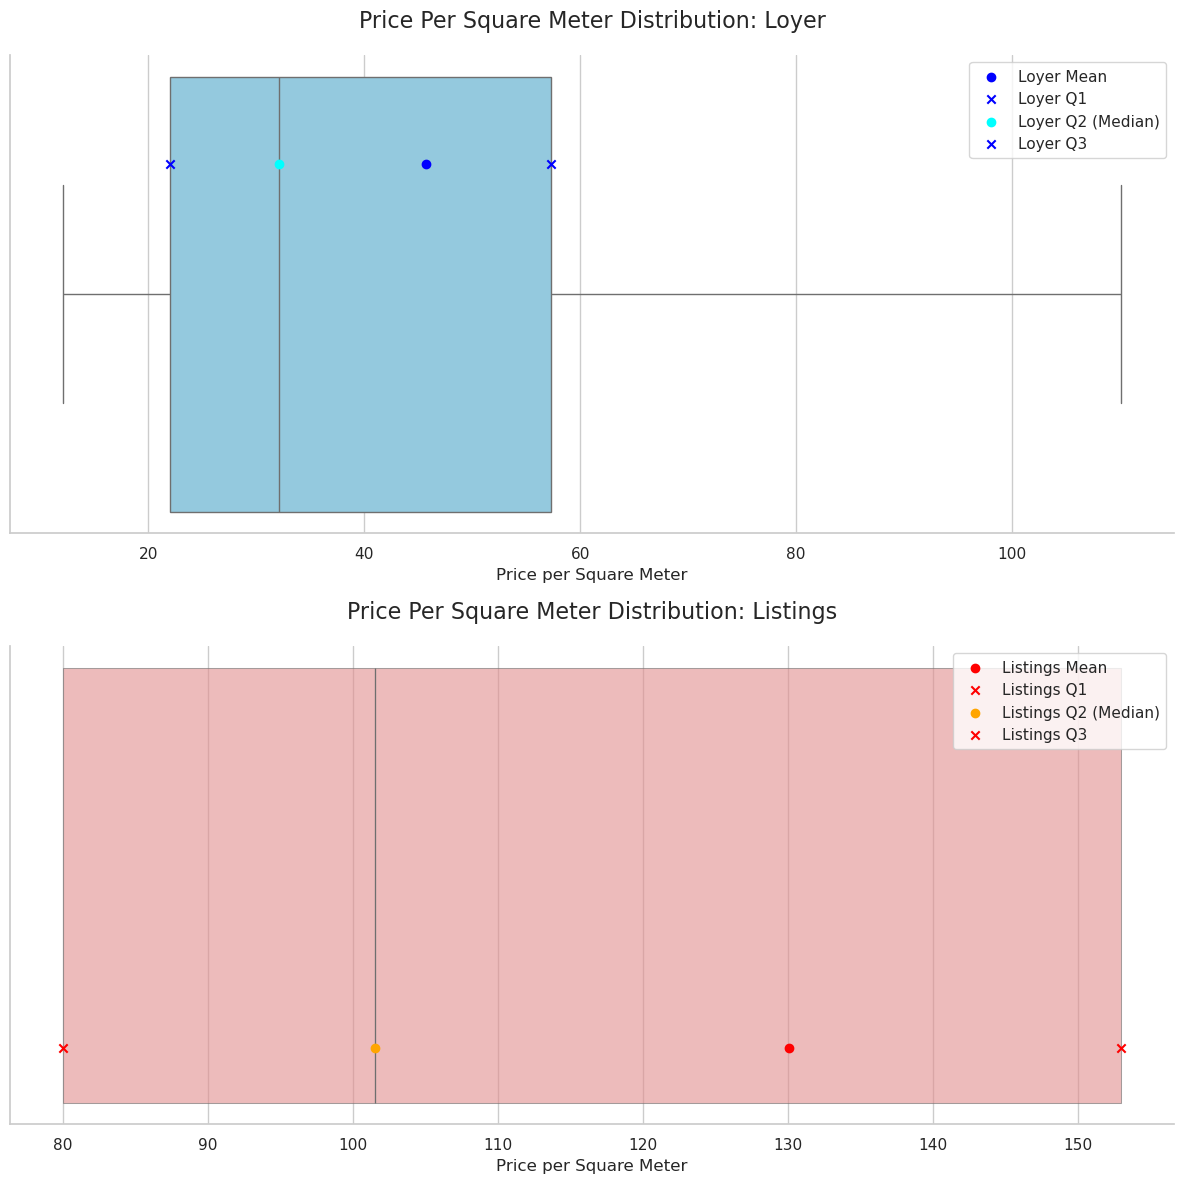

In [48]:

# Set a clean, modern style
sns.set_theme(style="whitegrid")

# Calculate special points for loyer_pd
loyer_summary = loyer_pd['price_per_m2'].describe()
loyer_mean = loyer_pd['price_per_m2'].mean()

# Calculate special points for listings_pd
listings_summary = listings_pd['price_per_m2'].describe()
listings_mean = listings_pd['price_per_m2'].mean()

# Create the figure and axes
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the boxplot for 'price_per_m2' in loyer_pd
sns.boxplot(
    x='price_per_m2', 
    data=loyer_pd, 
    color="skyblue", 
    width=0.5, 
    showfliers=False,  # Hide outliers for clarity
    boxprops={'zorder': 2},  # Ensure boxplot is on top layer
    ax=axes[0]
)
axes[0].scatter(loyer_mean, -0.15, color="blue", label="Loyer Mean", zorder=3)
axes[0].scatter(loyer_summary['25%'], -0.15, color="blue", marker="x", label="Loyer Q1", zorder=3)
axes[0].scatter(loyer_summary['50%'], -0.15, color="cyan", marker="o", label="Loyer Q2 (Median)", zorder=3)
axes[0].scatter(loyer_summary['75%'], -0.15, color="blue", marker="x", label="Loyer Q3", zorder=3)
axes[0].set_title("Price Per Square Meter Distribution: Loyer", fontsize=16, pad=20)
axes[0].set_xlabel("Price per Square Meter", fontsize=12)
axes[0].legend(loc="upper right")
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

# Plot the boxenplot for 'price_per_m2' in listings_pd
sns.boxenplot(
    x='price_per_m2', 
    data=listings_pd, 
    color="lightcoral", 
    width=0.4, 
    alpha=0.6,  # Slight transparency to show overlap
    showfliers=False,  # Hide outliers for clarity
    ax=axes[1]
)
axes[1].scatter(listings_mean, 0.15, color="red", label="Listings Mean", zorder=3)
axes[1].scatter(listings_summary['25%'], 0.15, color="red", marker="x", label="Listings Q1", zorder=3)
axes[1].scatter(listings_summary['50%'], 0.15, color="orange", marker="o", label="Listings Q2 (Median)", zorder=3)
axes[1].scatter(listings_summary['75%'], 0.15, color="red", marker="x", label="Listings Q3", zorder=3)
axes[1].set_title("Price Per Square Meter Distribution: Listings", fontsize=16, pad=20)
axes[1].set_xlabel("Price per Square Meter", fontsize=12)
axes[1].legend(loc="upper right")
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

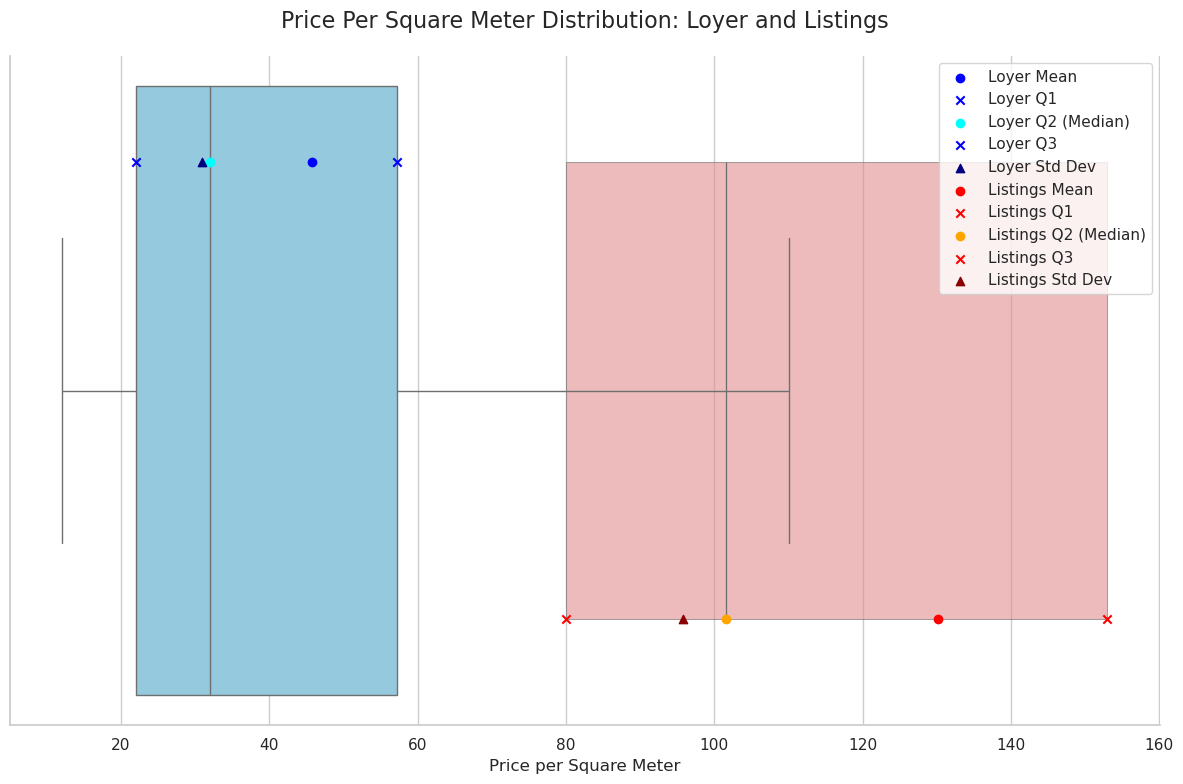

In [49]:
# Set a clean, modern style
sns.set_theme(style="whitegrid")

# Calculate special points for loyer_pd
loyer_summary = loyer_pd['price_per_m2'].describe()
loyer_mean = loyer_pd['price_per_m2'].mean()
loyer_std = loyer_pd['price_per_m2'].std()

# Calculate special points for listings_pd
listings_summary = listings_pd['price_per_m2'].describe()
listings_mean = listings_pd['price_per_m2'].mean()
listings_std = listings_pd['price_per_m2'].std()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the boxplot for 'price_per_m2' in loyer_pd
sns.boxplot(
    x='price_per_m2', 
    data=loyer_pd, 
    color="skyblue", 
    width=0.4, 
    showfliers=False,  # Hide outliers for clarity
    ax=ax
)
ax.scatter(loyer_mean, -0.15, color="blue", label="Loyer Mean", zorder=3)
ax.scatter(loyer_summary['25%'], -0.15, color="blue", marker="x", label="Loyer Q1", zorder=3)
ax.scatter(loyer_summary['50%'], -0.15, color="cyan", marker="o", label="Loyer Q2 (Median)", zorder=3)
ax.scatter(loyer_summary['75%'], -0.15, color="blue", marker="x", label="Loyer Q3", zorder=3)
ax.scatter(loyer_std, -0.15, color="navy", marker="^", label="Loyer Std Dev", zorder=3)

# Plot the boxenplot for 'price_per_m2' in listings_pd
sns.boxenplot(
    x='price_per_m2', 
    data=listings_pd, 
    color="lightcoral", 
    width=0.3, 
    alpha=0.6,  # Slight transparency to show overlap
    showfliers=False,  # Hide outliers for clarity
    ax=ax
)
ax.scatter(listings_mean, 0.15, color="red", label="Listings Mean", zorder=3)
ax.scatter(listings_summary['25%'], 0.15, color="red", marker="x", label="Listings Q1", zorder=3)
ax.scatter(listings_summary['50%'], 0.15, color="orange", marker="o", label="Listings Q2 (Median)", zorder=3)
ax.scatter(listings_summary['75%'], 0.15, color="red", marker="x", label="Listings Q3", zorder=3)
ax.scatter(listings_std, 0.15, color="darkred", marker="^", label="Listings Std Dev", zorder=3)

# Set titles and labels
ax.set_title("Price Per Square Meter Distribution: Loyer and Listings", fontsize=16, pad=20)
ax.set_xlabel("Price per Square Meter", fontsize=12)
ax.legend(loc="upper right")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()